In [1]:
import datetime
import os
import mthree
import numpy as np
from qiskit import Aer, BasicAer, IBMQ, transpile
from qiskit.providers.ibmq import IBMQBackend
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit_research.mzm_generation import KitaevHamiltonianExperiment
from qiskit_research.mzm_generation.experiment import CircuitParameters

In [2]:
# get backend

# hardware backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
hardware_backend = provider.get_backend('ibmq_lima')

# Aer simulator backend
noise_model = NoiseModel.from_backend(hardware_backend)
simulator_backend = AerSimulator(method='density_matrix',
                                 noise_model=noise_model)

backend = simulator_backend

In [3]:
# Hamiltonian parameters
n_modes = 3
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=10)
# occupied_orbitals_list = [(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]
occupied_orbitals_list = [(), (0,), (0, 1), (0, 1, 2)]

# qubits
# TODO choose qubits that minimize error rate
qubits = [0, 1, 2]

# number of shots
shots = 100000

# number of shots for readout error calibration
readout_calibration_shots = 100000

# experiment id used for saving data
experiment_id = f'{datetime.datetime.now().isoformat()}_{backend.name()}'

# create experiment
experiment = KitaevHamiltonianExperiment(
    experiment_id=experiment_id,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
)

In [4]:
%%time

# schedule readout calibration
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots)

# schedule experiment jobs
circuits_per_job = 100
data = experiment.run(
    backend=backend,
    circuits_per_job=circuits_per_job,
    shots=shots)
if isinstance(backend, IBMQBackend):
    data.save()

CPU times: user 1min 2s, sys: 389 ms, total: 1min 3s
Wall time: 1min


In [5]:
%%time

# save readout calibration
filename = f'data/{experiment_id}/readout_calibration.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
mit.cals_to_file(filename)
print(f'Readout calibration saved.')

Readout calibration saved.
CPU times: user 19 s, sys: 157 ms, total: 19.2 s
Wall time: 18 s


In [6]:
# wait for experiment results
data.block_for_results()

# TODO save data locally once it's supported
# See https://github.com/Qiskit/qiskit-experiments/issues/602

<ExperimentData[KitaevHamiltonianExperiment], backend: aer_simulator_density_matrix, status: ExperimentStatus.DONE, experiment_id: e5aed1cf-630a-4af2-b64a-91bf272d3426>

In [7]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')

In [3]:
db_experiment_id = 'c4b1fbe6-cb0a-4abc-88fe-24c027236c31'
# db_experiment_id = '0c062b9e-42dc-4234-8d98-ad7c4009e42e'
# db_experiment_id = '9e7e2259-35c1-412c-92ce-eb3daed8ff6a'
# db_experiment_id = 'c09ecdc3-1ddf-43a4-9ad5-77332e6618e1'

data = ExperimentData.load(db_experiment_id, provider.service('experiment'))

In [8]:
%%time
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

# load results
energy_exact = data.analysis_results('energy_exact').value
energy_raw = data.analysis_results('energy_raw').value
energy_mem = data.analysis_results('energy_mem').value
energy_ps = data.analysis_results('energy_ps').value
energy_pur = data.analysis_results('energy_pur').value
edge_correlation_exact = data.analysis_results('edge_correlation_exact').value
edge_correlation_raw = data.analysis_results('edge_correlation_raw').value
edge_correlation_mem = data.analysis_results('edge_correlation_mem').value
edge_correlation_ps = data.analysis_results('edge_correlation_ps').value
edge_correlation_pur = data.analysis_results('edge_correlation_pur').value
parity_exact = data.analysis_results('parity_exact').value
parity_raw = data.analysis_results('parity_raw').value
parity_mem = data.analysis_results('parity_mem').value
number_exact = data.analysis_results('number_exact').value
number_raw = data.analysis_results('number_raw').value
number_mem = data.analysis_results('number_mem').value
energy_error_raw, energy_error_stddev_raw = data.analysis_results('energy_error_raw').value
energy_error_mem, energy_error_stddev_mem = data.analysis_results('energy_error_mem').value
energy_error_ps, energy_error_stddev_ps = data.analysis_results('energy_error_ps').value
energy_error_pur, energy_error_stddev_pur = data.analysis_results('energy_error_pur').value

/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:43: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


CPU times: user 3.61 s, sys: 1.57 s, total: 5.18 s
Wall time: 4.81 s


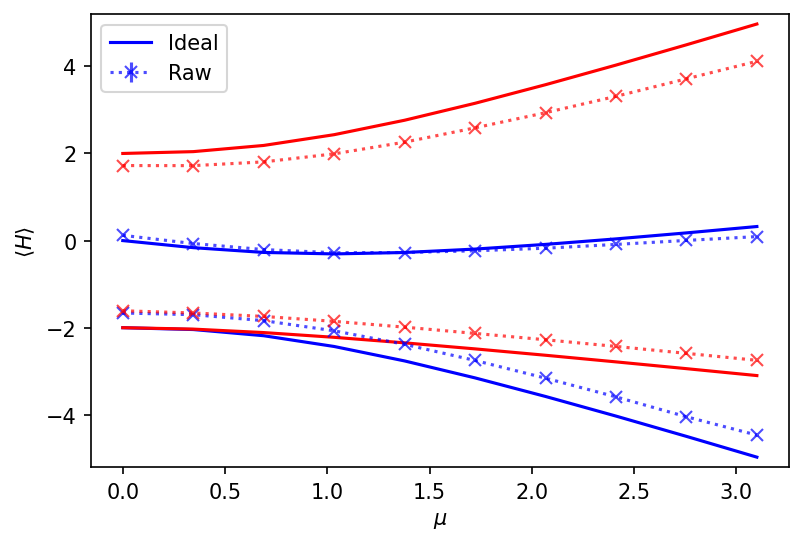

In [9]:
dpi = 150

# plot energy, raw data only
fig, ax = plt.subplots(dpi=150)
for occupied_orbitals, energies in energy_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, energies, label=label, color=color
    )
for occupied_orbitals, (energies, stddevs) in energy_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
ax.set_ylim(-5.2, 5.2)
ax.legend()

data.add_figures(fig, 'energy_raw', overwrite=True)
plt.show()

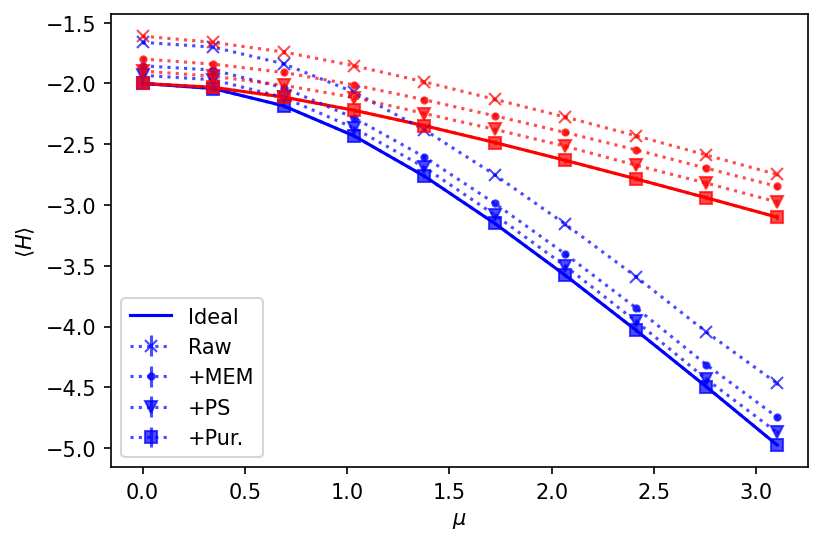

In [10]:
# plot energy, raw data plus error mitigation
fig, ax = plt.subplots(dpi=dpi)
occupied_orbitals_list = [(), (0,)]
for occupied_orbitals in occupied_orbitals_list:
    energies = energy_exact[occupied_orbitals]
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(
        chemical_potential_values, energies, label=label, color=color
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_raw[occupied_orbitals]
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_mem[occupied_orbitals]
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_ps[occupied_orbitals]
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals in occupied_orbitals_list:
    energies, stddevs = energy_pur[occupied_orbitals]
    label = "+Pur." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        energies,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle H \rangle$")
#ax.set_ylim(-5.2, -1)
ax.legend()

data.add_figures(fig, 'energy_mit', overwrite=True)
plt.show()

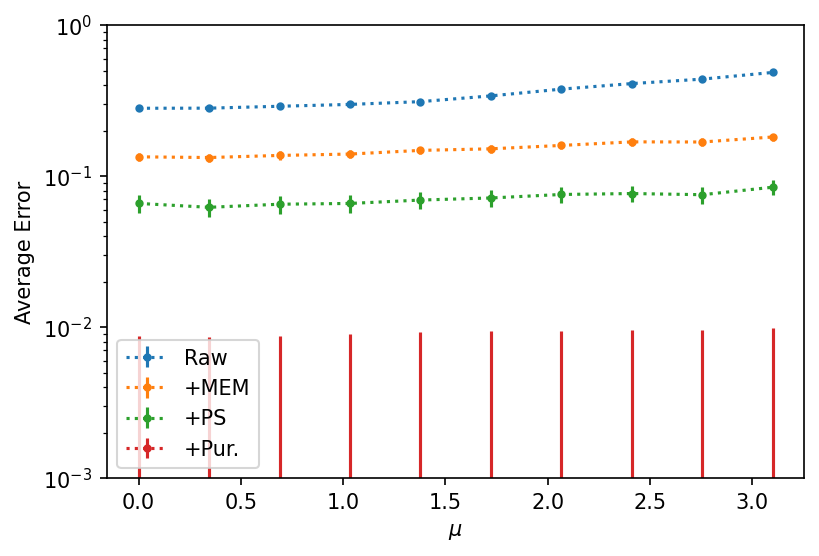

In [13]:
# plot average error in energy
fig, ax = plt.subplots(dpi=dpi)
ax.errorbar(
    chemical_potential_values,
    energy_error_raw,
    yerr=2 * energy_error_stddev_raw,
    fmt=".:",
    label="Raw",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_mem,
    yerr=2 * energy_error_stddev_mem,
    fmt=".:",
    label="+MEM",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_ps,
    yerr=2 * energy_error_stddev_ps,
    fmt=".:",
    label="+PS",
)
ax.errorbar(
    chemical_potential_values,
    energy_error_pur,
    yerr=2 * energy_error_stddev_pur,
    fmt=".:",
    label="+Pur.",
)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"Average Error")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.legend()

data.add_figures(fig, 'energy_error_mit', overwrite=True)
plt.show()

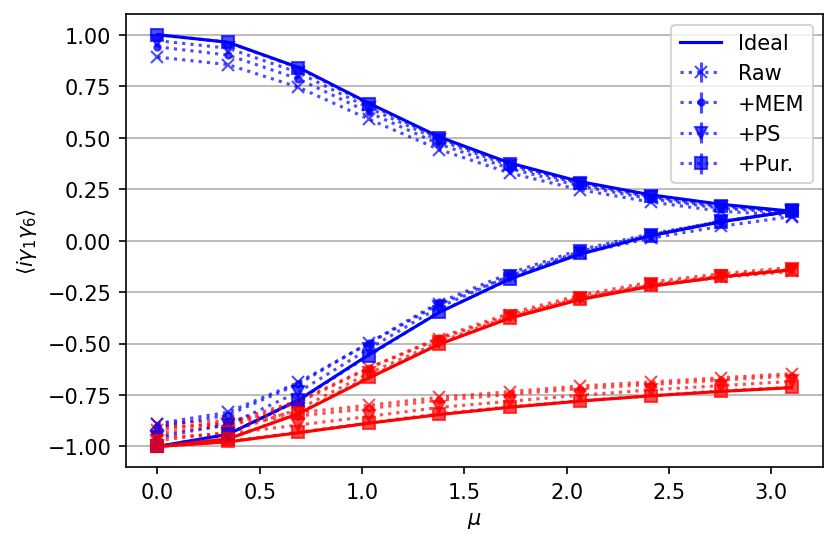

In [14]:
# plot edge correlation
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, edge_correlations in edge_correlation_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(chemical_potential_values, edge_correlations, label=label, color=color)
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_ps.items():
    label = "+PS" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="v:",
        label=label,
        color=color,
        alpha=0.7
    )
for occupied_orbitals, (edge_correlations, stddevs) in edge_correlation_pur.items():
    label = "+Pur." if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        edge_correlations,
        yerr=2 * np.array(stddevs),
        fmt="s:",
        label=label,
        color=color,
        alpha=0.7
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle i \gamma_1 \gamma_6 \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.grid(axis='y')
ax.legend()

data.add_figures(fig, 'edge_correlation_raw_mem', overwrite=True)
plt.show()

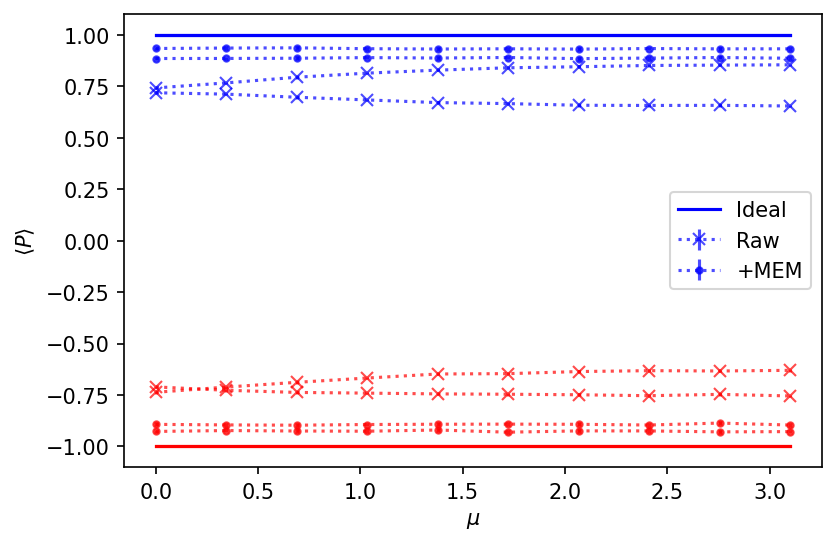

In [15]:
# plot parity
fig, ax = plt.subplots(dpi=dpi)
for occupied_orbitals, parities in parity_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.plot(chemical_potential_values, parities, label=label, color=color)
for occupied_orbitals, (parities, stddevs) in parity_raw.items():
    label = "Raw" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=color,
        alpha=0.7,
    )
for occupied_orbitals, (parities, stddevs) in parity_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    color = "red" if len(occupied_orbitals) % 2 else "blue"
    ax.errorbar(
        chemical_potential_values,
        parities,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=color,
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle P \rangle$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

data.add_figures(fig, 'parity_raw_mem', overwrite=True)
plt.show()

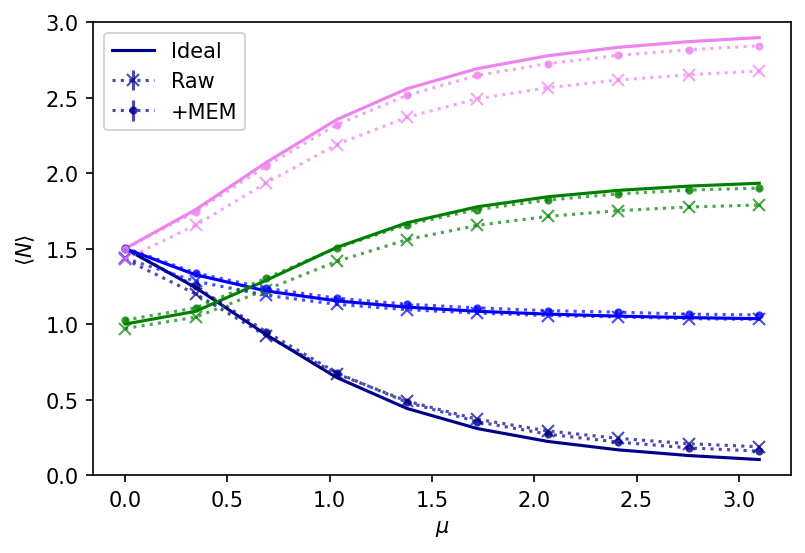

In [16]:
# plot number
fig, ax = plt.subplots(dpi=dpi)
colors = {
    (): "darkblue",
    (0,): "blue",
    (1,): "cyan",
    (2,): "greenyellow",
    (0, 1): "green",
    (0, 2): "orange",
    (1, 2): "red",
    (0, 1, 2): "violet",
}
for occupied_orbitals, numbers in number_exact.items():
    label = "Ideal" if not occupied_orbitals else None
    ax.plot(
        chemical_potential_values,
        numbers,
        label=label,
        color=colors[occupied_orbitals],
    )
for occupied_orbitals, (numbers, stddevs) in number_raw.items():
    label = "Raw" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt="x:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
for occupied_orbitals, (numbers, stddevs) in number_mem.items():
    label = "+MEM" if not occupied_orbitals else None
    ax.errorbar(
        chemical_potential_values,
        numbers,
        yerr=2 * np.array(stddevs),
        fmt=".:",
        label=label,
        color=colors[occupied_orbitals],
        alpha=0.7,
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle N \rangle$")
ax.set_ylim(0, 3)
ax.legend()

data.add_figures(fig, 'number_raw_mem', overwrite=True)
plt.show()